## VAE implementation

### First test
we implement and train a VAE on MNIST dataset; and see how it works as generator.

In [28]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt

import time

We load and normalise the dataset

In [52]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [53]:
train_size = len(train_images)
test_size = len(test_images)
batch_size = 32

In [54]:
#Now we shuffle and take batches
train_images = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_images = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

Now we build our VAE implementing the Encoder and the Decoder

In [55]:
class C_VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(C_VAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer( input_shape = (28,28,1) ),
            tf.keras.layers.Conv2D( filters=32, kernel_size=3, strides=(2,2), activation='relu'),
            tf.keras.layers.Conv2D( filters=64, kernel_size=3, strides=(2,2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense( units = latent_dim + latent_dim )
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer( input_shape=(latent_dim,)),
            tf.keras.layers.Dense( units = 7*7*32 , activation='relu'),
            tf.keras.layers.Reshape( target_shape = (7,7,32)),
            tf.keras.layers.Conv2DTranspose( filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose( filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose( filters=1, kernel_size=3, strides=1, padding='same' )
        ])
    
    @tf.function # Notice the use of `tf.function`. This annotation causes the function to be "compiled".
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [56]:
latent_dim = 2
vae = C_VAE( latent_dim )

we write training utility functions

In [57]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum( -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """
    Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [58]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [59]:
epochs = 15
dataset = train_images

for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
        train_step(vae, image_batch, optimizer)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start) )

Time for epoch 1 is 9.369109392166138 sec
Time for epoch 2 is 8.870012521743774 sec
Time for epoch 3 is 8.813559532165527 sec
Time for epoch 4 is 8.664205551147461 sec
Time for epoch 5 is 8.756137371063232 sec
Time for epoch 6 is 8.735744714736938 sec
Time for epoch 7 is 8.68688440322876 sec
Time for epoch 8 is 8.784418106079102 sec
Time for epoch 9 is 8.885072708129883 sec
Time for epoch 10 is 8.894982814788818 sec
Time for epoch 11 is 8.85746955871582 sec
Time for epoch 12 is 8.73798155784607 sec
Time for epoch 13 is 8.767415046691895 sec
Time for epoch 14 is 8.902135133743286 sec
Time for epoch 15 is 8.642020225524902 sec


To judge the training of our model, we need to see if it is really able to reproduce the test images

In [60]:
def generate_and_show_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()
    
    
num_examples_to_generate = 16
# keeping the random vector constant for generation (prediction) so it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal( shape=[num_examples_to_generate, latent_dim] )

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_images.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]


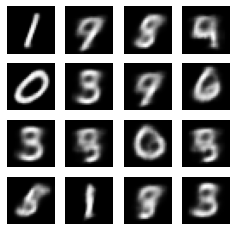

In [61]:
loss = tf.keras.metrics.Mean()
for test_x in test_images:
    loss(compute_loss(vae, test_x))
elbo = -loss.result()
#display.clear_output(wait=False)
#print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
generate_and_show_images(vae, epochs, test_sample)

So, we see it is able to generate meaningfull images.
Now we explore the latent space.

In [62]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
        digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
        image[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

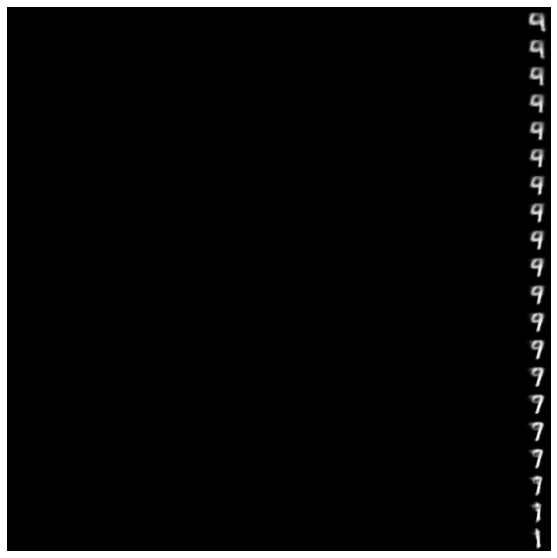

In [64]:
plot_latent_images(vae, 20)

### Second test
Now we test our model on CIFAR10 dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [ ]:
train_size = len(train_images)
test_size = len(test_images)
batch_size = 32

In [ ]:
#Now we shuffle and take batches
train_images = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_images = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']